In [1]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification
from safetensors.torch import load_file
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#globals
path_results = 'C:/Users/arian/OneDrive/Робочий стіл/lab emotions/model/results'
path_training_dataset = 'C:/Users/arian/OneDrive/Робочий стіл/lab emotions/model/training.csv'

In [3]:
def load_model():
    try:
        model_path = path_results

        config_path = f"{model_path}/config.json"
        model_weights_path = f"{model_path}/model.safetensors"

        tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

        state_dict = load_file(model_weights_path)

        model = RobertaForSequenceClassification.from_pretrained(
            model_path,
            config=config_path,
            state_dict=state_dict,
            output_hidden_states=True  # This ensures that hidden states are returned
        )
        
        return tokenizer, model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

tokenizer, model = load_model()

if tokenizer is None or model is None:
    print("Failed to load the model.")
    exit(1)

In [4]:
def classify_text(text):
    try:
        # Tokenize input text
        inputs = tokenizer(
            text,
            return_tensors="pt",       # Return PyTorch tensors
            truncation=True,           # Truncate input to max length
            padding=True,              # Pad the input if shorter than max length
            max_length=512             # Set the max sequence length
        )
        
        # Ensure the model is in evaluation mode
        model.eval()

        # Disable gradient calculations (not needed for inference)
        with torch.no_grad():
            # Get model predictions
            outputs = model(**inputs)
            logits = outputs.logits

        probabilities = torch.softmax(logits, dim=1).squeeze().tolist() # Convert logits to probabilities

        predicted_class_idx = np.argmax(probabilities) # Get the predicted class (index of max probability)

        emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

        predicted_emotion = emotion_labels[predicted_class_idx]
        return predicted_emotion
    except Exception as e:
        print(f"Error during classification: {e}")
        return None

In [5]:
def get_embeddings(texts):
    embeddings = []
    for text in texts:
        # Tokenize and get input IDs
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs) # Ensure to pass the output_hidden_states=True argument
        
        hidden_states = outputs.hidden_states # Extract the hidden states (the last hidden state)
        last_hidden_state = hidden_states[-1] # The last hidden state is the last element in the hidden_states tuple

        # Use the mean of the hidden states for the embedding (mean over tokens)
        embedding = last_hidden_state.mean(dim=1).squeeze().numpy()  # Mean pooling to get one embedding per sentence
        embeddings.append(embedding)
    return embeddings

In [6]:
def get_labels(texts):
    labels = []
    for text in texts:
        #get lables from model TODO
        emotion = classify_text(text)
        labels.append(emotion)
    return labels

In [7]:
label_to_color = {
        'anger': 'black',    # anger
        'fear': 'purple',   # fear
        'sadness': 'blue',     # sadness
        'surprise': 'green',     # surprise
        'joy': 'orange',   # joy
        'love': 'red'      # love
    }
emotion_labels = ['anger', 'fear', 'sadness', 'surprise', 'joy', 'love']

In [8]:
def prepare_data_pca(texts):
    embeddings = get_embeddings(texts)
    labels = get_labels(texts)

    colors = [label_to_color[label] for label in labels]
    # print(colors)
    
    return embeddings, colors

In [9]:
def pca_and_plot_2d(embeddings, colors):
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)  # Assuming 'embeddings' is your datase
    
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, s=3)
    plt.title('PCA of Text Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    # Add legend for emotions
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
               for color in label_to_color.values()]
    plt.legend(handles=handles, labels=emotion_labels, title="Emotions")
    plt.show()

In [10]:
def pca_and_plot_3d(embeddings, colors):
    
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(embeddings)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=colors, s=3)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA of Text Embeddings')
    
    # Add legend for emotions
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
               for color in label_to_color.values()]
    plt.legend(handles=handles, labels=emotion_labels, title="Emotions")
    plt.show()

In [11]:
# Get text from training dataset 
train_df = pd.read_csv(path_training_dataset)

texts = train_df['text'].tolist()

In [12]:
embeddings, colors = prepare_data_pca(texts)

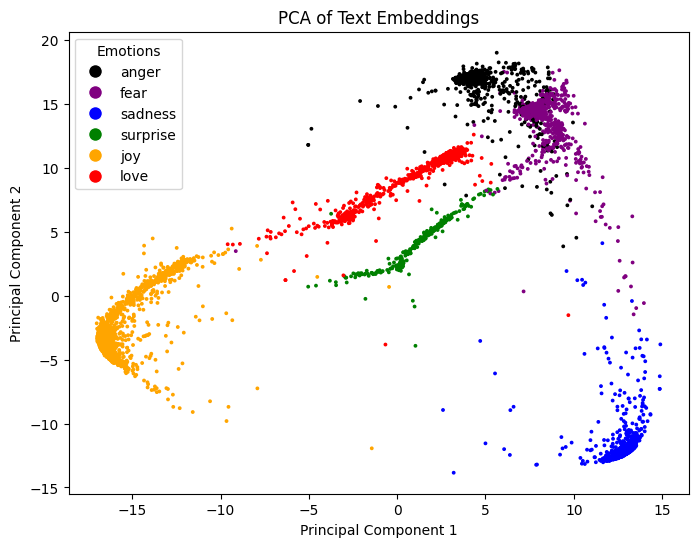

In [13]:
pca_and_plot_2d(embeddings, colors)

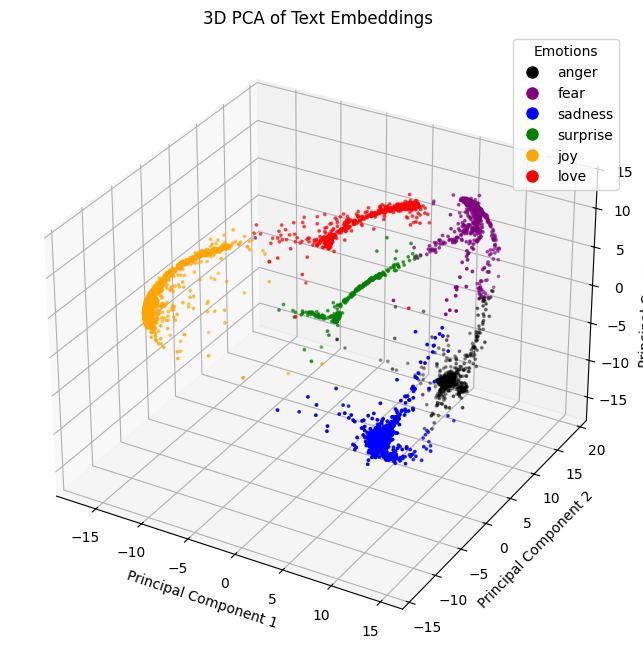

In [14]:
pca_and_plot_3d(embeddings, colors)

In [15]:
texts = [ #fear, anger and sadness
    "I am so angry right now!", "I feel so scared!", "I can't stop crying!", 
    "This makes me furious!", "I feel like I'm losing control!", "I am terrified!", 
    "Everything is falling apart!", "This is so frustrating!", "I'm so afraid of what's going to happen!", 
    "I feel so hopeless!", "I can't take it anymore!", "I'm shaking with fear!", "This makes my blood boil!", 
    "I am overwhelmed with anger!", "I feel trapped!", "I'm so scared of the future!", "I just want to scream!", 
    "I feel so down!", "This is unbearable!", "I don't know what to do anymore!", "I can't breathe, I'm so scared!", 
    "Everything feels so wrong!", "I'm really upset about this!", "I'm full of dread!", "I feel so helpless!", 
    "I can't stop worrying!", "I'm so disappointed!", "This is more than I can handle!", "I feel so lonely!", 
    "I feel like no one cares!", "I am drowning in sadness!", "I'm scared to face tomorrow!", "I feel so angry I could explode!", 
    "I am so frustrated!", "I'm afraid to go outside!", "I feel like I'm losing myself!", "I can't stop feeling anxious!", 
    "I am so heartbroken!", "I feel so nervous all the time!", "I just want to run away from everything!", 
    "I'm scared of what will happen next!", "I feel completely broken!", "This is just too much to handle!", 
    "I am so mad about this!", "I feel so abandoned!", "I just want everything to stop!", "I'm overwhelmed with sadness!", 
    "I feel so empty inside!", "I can't handle all this fear!", "I'm so upset with myself!", "I feel lost and confused!", 
    "Everything feels so unfair!", "I feel like I'm suffocating!", "I'm filled with regret!" 
]

In [16]:
embeddings, colors = prepare_data_pca(texts)

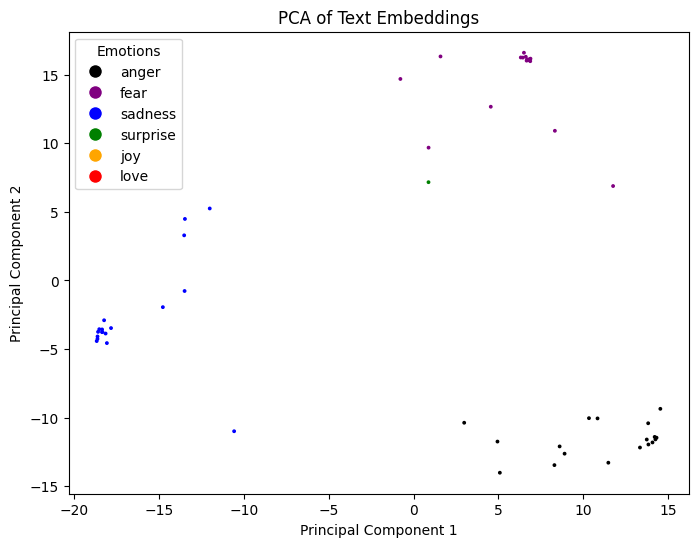

In [17]:
pca_and_plot_2d(embeddings, colors)

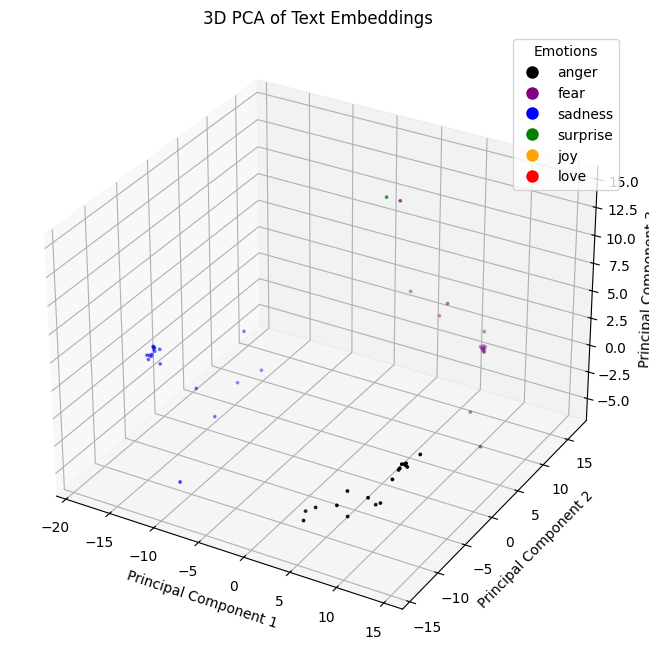

In [18]:
pca_and_plot_3d(embeddings, colors)

In [19]:
#love
texts = [
    "I love you so much!", "You mean the world to me!", "I can't imagine my life without you!", 
    "My heart belongs to you!", "I am so in love with you!", "You make me feel so special!", 
    "Every moment with you is pure joy!", "You complete me!", "I adore you more than words can express!", 
    "You are my everything!", "I am so grateful to have you in my life!", "You are the love of my life!", 
    "I love how you make me feel!", "I feel so lucky to have you by my side!", "You make my heart skip a beat!", 
    "I fall in love with you more every day!", "You are my soulmate!", "I love you more than anything in this world!", 
    "Being with you feels like home!", "You light up my life!", "I will love you forever!", 
    "My love for you is endless!", "You are my reason for everything!", "I feel so blessed to have you!", 
    "You make my world a better place!", "You are the best thing that ever happened to me!", 
    "I can't wait to spend the rest of my life with you!", "My heart beats for you!", "I cherish every moment with you!", 
    "I am deeply in love with you!", "You make every day brighter!", "You are the center of my universe!", 
    "I will always be there for you, no matter what!", "You are my one true love!", "You are everything I've ever wanted!", 
    "I will always cherish and adore you!", "You make my life meaningful!", "I am so thankful for your love!", 
    "My heart is filled with love for you!", "I can't get enough of you!", "You are the light of my life!", 
    "I am so proud to be with you!", "I never want to let you go!", "I am so thankful for your kindness and love!", 
    "Every time I see you, I fall in love all over again!", "You are my greatest treasure!", "I feel so safe with you!", 
    "I love you with all my heart!", "You are my forever and always!", "I can't imagine a future without you!", 
    "You make me feel loved and appreciated!", "I am so happy with you!", "You are the best part of my day!", 
    "You make me feel like the luckiest person alive!", "You are the reason I smile every day!"
]

In [20]:
embeddings, colors = prepare_data_pca(texts)

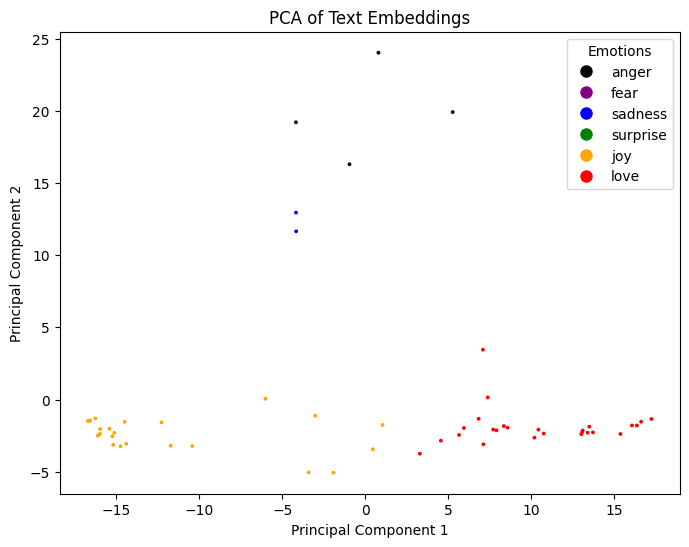

In [25]:
pca_and_plot_2d(embeddings, colors)

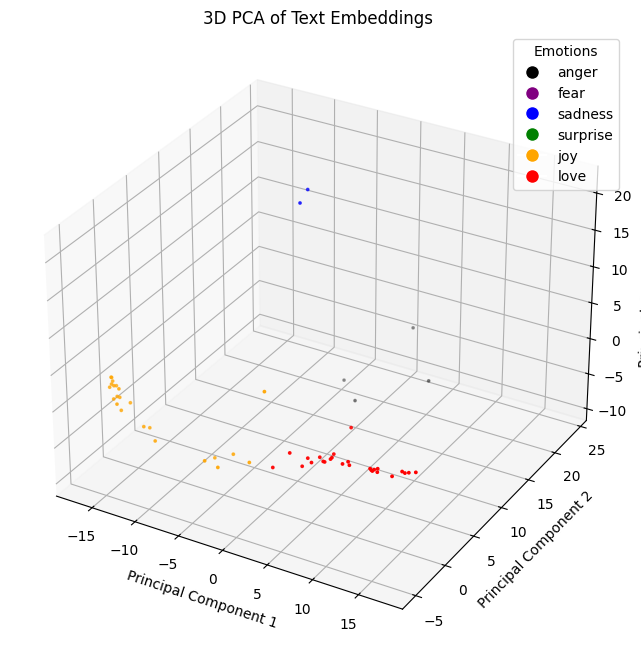

In [26]:
pca_and_plot_3d(embeddings, colors)

In [27]:
#joy
texts = [
    "I am so happy right now!", "This is the best day ever!", "I can't stop smiling!", 
    "I feel on top of the world!", "Everything is going perfectly!", "I am filled with joy!", 
    "My heart is overflowing with happiness!", "This is pure joy!", "I feel so alive!", 
    "I am so grateful for this moment!", "I'm walking on air!", "This is such a wonderful feeling!", 
    "My soul is dancing with happiness!", "I can't believe how amazing this is!", "Life feels so beautiful right now!", 
    "I am in awe of how great things are!", "This is the happiest I've ever been!", "I feel so free and joyful!", 
    "I have never felt so full of joy!", "I feel like I'm floating on cloud nine!", "Everything feels so perfect!", 
    "I am overflowing with happiness!", "I can't stop laughing!", "I feel so blessed and joyful!", 
    "I feel like a kid again, so full of joy!", "This is a moment I will cherish forever!", 
    "I am so thankful for this happiness!", "Everything is just right!", "I'm filled with so much positivity!", 
    "I can't stop feeling this incredible joy!", "I'm so excited for what comes next!", 
    "This moment feels like magic!", "I am completely at peace and joyful!", "This is exactly what I needed!", 
    "I feel so lighthearted and happy!", "I'm in the best mood today!", "I feel so content and joyful!", 
    "I am so happy I could burst!", "Everything is shining so brightly right now!", "I can't stop smiling from ear to ear!", 
    "I'm dancing with happiness!", "I feel so happy and carefree!", "The world feels so good right now!", 
    "I am so excited for this journey!", "I feel so joyful just being here!", "I am full of energy and joy!", 
    "This is the happiest I have ever been!", "I feel like I can conquer anything with this joy!", 
    "Every little thing feels so exciting!", "I am absolutely delighted!", "I am overjoyed with gratitude!", 
    "I feel like everything is falling into place!", "I am bursting with happiness and excitement!"
]

In [28]:
embeddings, colors = prepare_data_pca(texts)

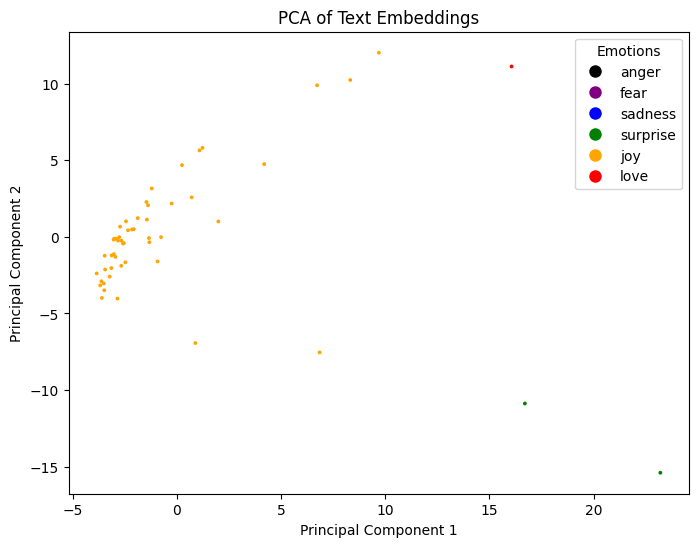

In [29]:
pca_and_plot_2d(embeddings, colors)

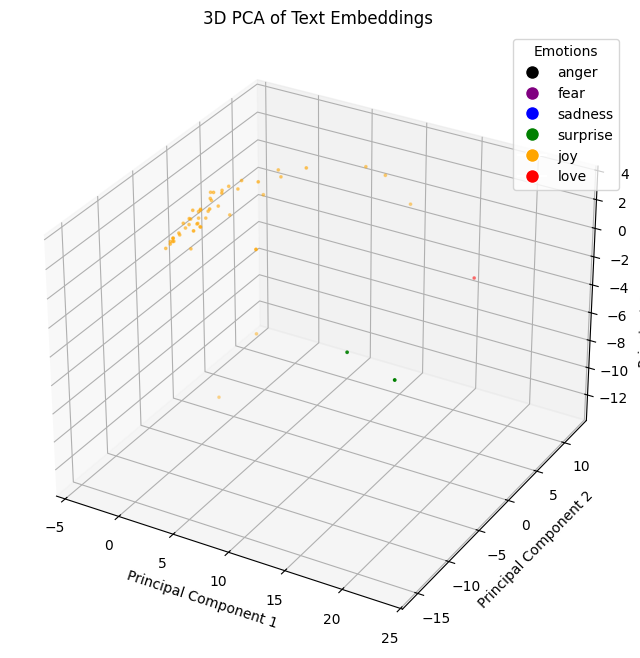

In [30]:
pca_and_plot_3d(embeddings, colors)

In [31]:
#surprized
texts = [
    "I can't believe this is happening!", "This is completely unexpected!", "Wow, I'm so surprised!", 
    "I never saw that coming!", "I am in shock right now!", "This is a total surprise!", "I didn't expect this at all!", 
    "I am absolutely amazed!", "This is beyond anything I imagined!", "I'm speechless!", 
    "I can't believe my eyes!", "This is such a pleasant surprise!", "I'm completely stunned!", 
    "I wasn't expecting that!", "This is incredible!", "I am blown away!", "This is so unexpected and exciting!", 
    "I'm in total disbelief!", "This has totally caught me off guard!", "I am amazed by this!", 
    "I don't know how to process this, it's such a surprise!", "This is way more than I anticipated!", 
    "I feel like I'm dreaming!", "I never thought this would happen!", "This is a huge surprise!", 
    "I can't believe this just happened!", "I feel so shocked and amazed!", "This is a total game-changer!", 
    "What a fantastic surprise!", "I am so surprised and happy!", "This is the best surprise ever!", 
    "I am totally caught off guard!", "This is just unbelievable!", "I feel like I'm in a movie right now!", 
    "I can't wrap my head around this!", "I am totally floored by this!", "This is more than I could have hoped for!", 
    "I'm in shock but so happy!", "I don't even know what to say, I'm so surprised!", "This is beyond my wildest expectations!", 
    "I am so taken aback by this!", "I'm so shocked I can't stop smiling!", "I never thought this would be possible!", 
    "This is the most surprising thing that has ever happened to me!", "I can't believe how amazing this is!", 
    "I feel like this is a dream come true!", "This is a pleasant shock!", "I am genuinely stunned by this!", 
    "I feel like my world just turned upside down!", "This is more than I could ever imagine!", 
    "I'm overwhelmed by how surprising this is!", "This is the surprise of a lifetime!"
]

In [32]:
embeddings, colors = prepare_data_pca(texts)

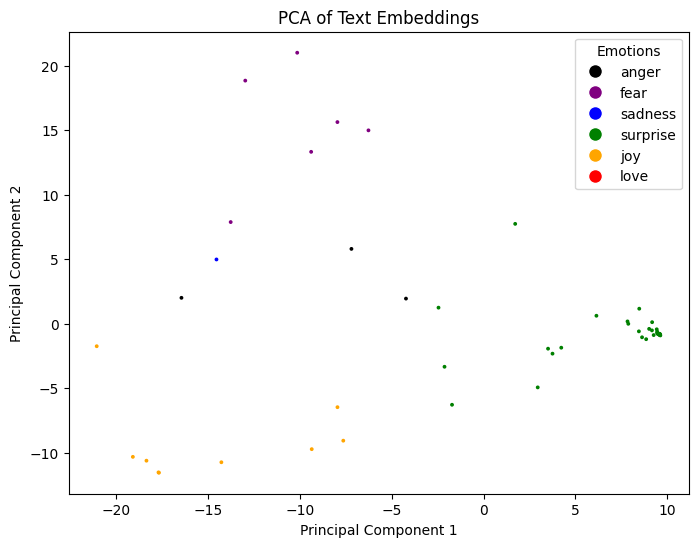

In [33]:
pca_and_plot_2d(embeddings, colors)

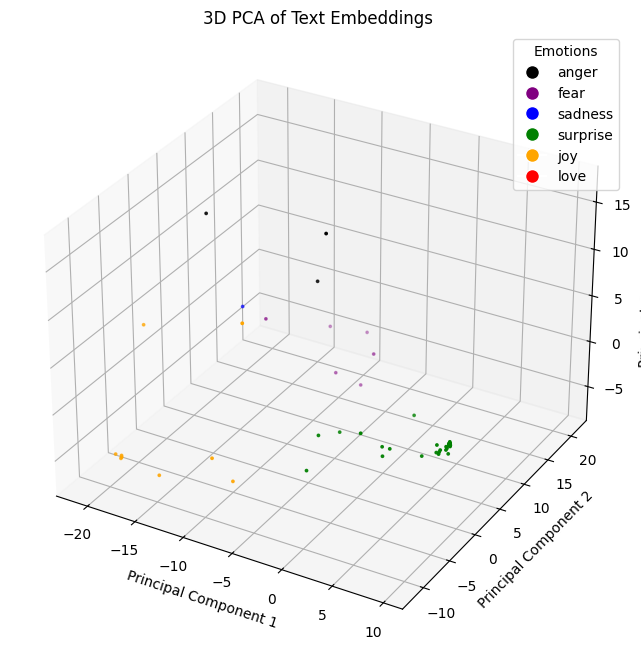

In [34]:
pca_and_plot_3d(embeddings, colors)

In [35]:
#sadness 
texts = [
    "I feel so sad right now.", "I'm heartbroken.", "Everything feels so empty.", "I can't stop crying.", 
    "I feel lost and alone.", "My heart feels heavy.", "I don't know how to keep going.", "This is so painful.", 
    "I'm overwhelmed with sadness.", "I feel completely broken.", "I just want to be left alone.", "I feel like I'm drowning.", 
    "I'm so disappointed.", "Everything feels so wrong.", "I can't shake this sadness.", "I'm so lonely.", 
    "This is the hardest thing I've ever gone through.", "I feel hopeless.", "I don't know what to do anymore.", 
    "I'm just not okay.", "I feel like I'm fading away.", "I'm stuck in this sadness.", "I feel like nothing matters anymore.", 
    "I just can't seem to feel happy.", "I'm carrying this sadness with me everywhere I go.", "I'm so tired of feeling this way.", 
    "I feel so disconnected from everyone.", "I don't feel like myself anymore.", "I feel like everything is falling apart.", 
    "I just want to disappear.", "This sadness is consuming me.", "I feel like I'm lost in the dark.", "I can't escape this feeling.", 
    "I don't know how to move on from this.", "I feel so empty inside.", "I can't find any joy in anything.", 
    "I wish things were different.", "I'm grieving something I can't explain.", "I feel trapped in my own emotions.", 
    "I feel like I'm walking through life in a fog.", "I'm so overwhelmed by sadness.", "I just can't stop thinking about it.", 
    "My heart aches with sadness.", "I can't seem to find peace.", "I feel like nothing will ever get better.", 
    "I'm just so tired of feeling this way.", "I feel like I'm never going to be happy again.", "This sadness won't go away.", 
    "I can't seem to find any light in the darkness.", "I feel like I'm carrying the weight of the world.", 
    "I'm so lost in my thoughts and sadness.", "Everything is just too much to handle right now."
]

In [36]:
embeddings, colors = prepare_data_pca(texts)

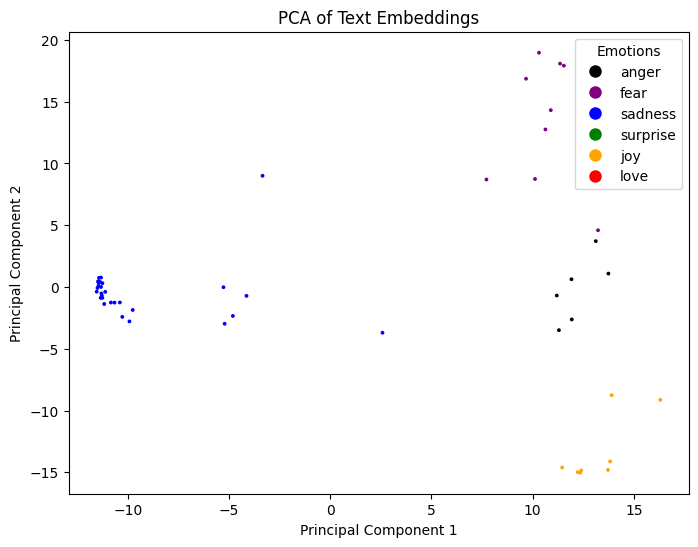

In [37]:
pca_and_plot_2d(embeddings, colors)

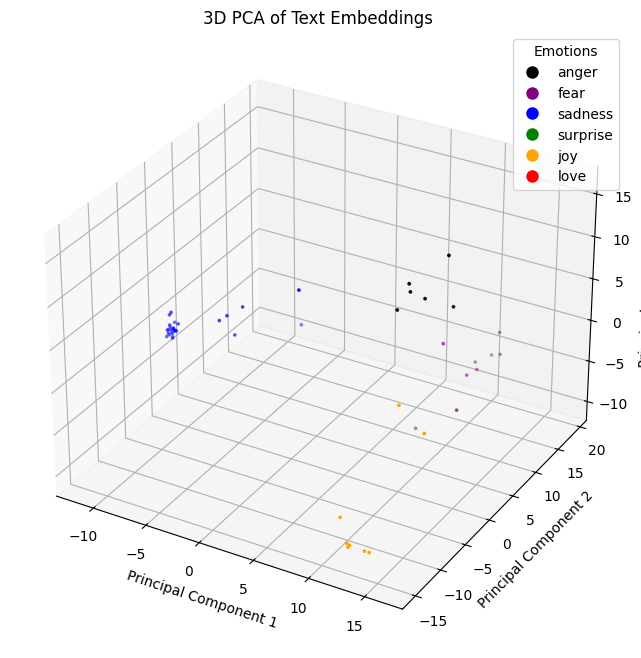

In [38]:
pca_and_plot_3d(embeddings, colors)

In [39]:
#fear
texts = [
    "I am so scared right now!", "I feel terrified!", "I'm afraid of what's going to happen!", "I can't stop shaking!", 
    "This is too much for me to handle!", "I don't know what to do, I'm so scared!", "I feel paralyzed by fear!", 
    "My heart is racing with fear!", "I'm afraid of the unknown!", "I'm scared I won't be able to handle this!", 
    "I feel trapped in my fear!", "I'm overwhelmed by fear!", "I can't escape this fear!", "I feel like something bad is going to happen!", 
    "I can't breathe, I'm so scared!", "I'm filled with dread!", "I'm afraid of the future!", "This fear is consuming me!", 
    "I don't know how to face this fear!", "I feel like I'm suffocating!", "I'm so anxious, I can’t think straight!", 
    "I’m terrified of making a mistake!", "I fear that everything will fall apart!", "I feel like I'm losing control!", 
    "I feel so small and helpless right now!", "I don’t know how to escape this feeling of fear!", 
    "I'm afraid of what could happen next!", "This fear feels like it’s taking over my body!", 
    "I can't stop worrying about everything!", "I fear that I won't be good enough!", "I'm scared to face reality!", 
    "This fear is making my mind spiral!", "I feel like I'm on the edge!", "I'm scared of what people will think!", 
    "I feel like I can't trust anyone anymore!", "This fear is so overwhelming, I don’t know how to cope!", 
    "I feel so vulnerable!", "I can't calm my nerves, I’m so afraid!", "I'm worried about the worst-case scenario!", 
    "I feel like I'm being consumed by my fears!", "I’m afraid to fail!", "This fear has such a tight grip on me!", 
    "I feel like something bad is always lurking around the corner!", "I feel so anxious about everything!", 
    "I’m afraid of being judged!", "I feel so powerless right now!", "I fear I won’t be able to overcome this!", 
    "I’m scared to make the wrong move!", "I can't shake the feeling of fear!", "I'm afraid to take risks!", 
    "This fear is preventing me from moving forward!"
]

In [40]:
embeddings, colors = prepare_data_pca(texts)

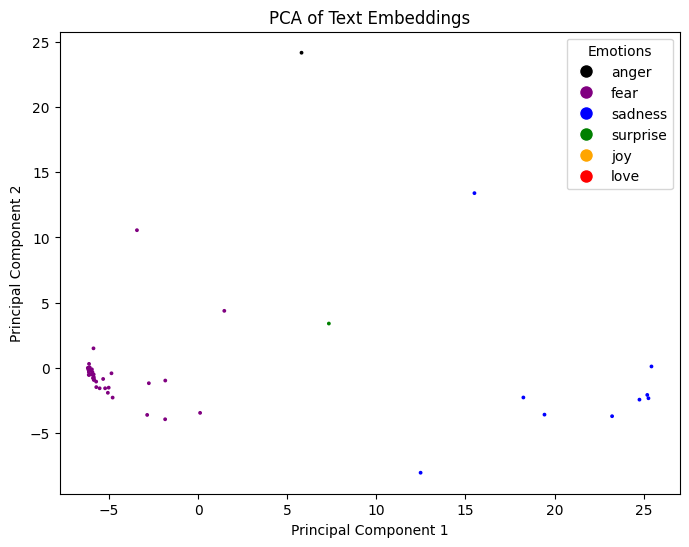

In [41]:
pca_and_plot_2d(embeddings, colors)

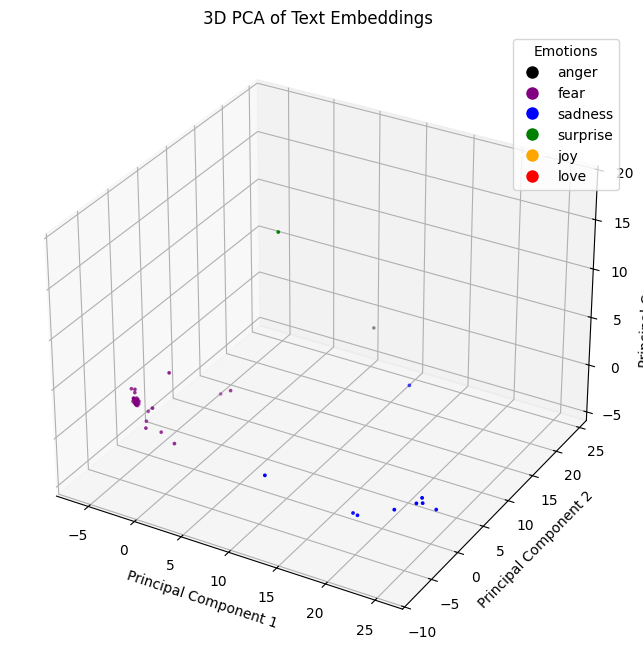

In [42]:
pca_and_plot_3d(embeddings, colors)

In [43]:
#anger 
texts = [
    "I am so angry right now!", "This is so frustrating!", "I can't believe this is happening!", 
    "I'm furious!", "I can't stand this anymore!", "I'm livid!", "This is making me so mad!", 
    "I feel like I’m about to explode!", "I am so pissed off!", "I can't control my anger!", 
    "This is completely unacceptable!", "I’m so angry, I don’t know what to do with myself!", 
    "This is so infuriating!", "I’m so fed up with this!", "I feel like I’ve had enough!", 
    "I’m boiling with rage!", "This situation is making me so mad!", "I can’t take it anymore!", 
    "I am seething with anger!", "I feel like punching something!", "This is driving me crazy!", 
    "I am filled with so much anger!", "Why is this happening to me?", "I am so angry I could scream!", 
    "This is unbelievable!", "I'm so frustrated with this whole thing!", "I am losing my patience!", 
    "This makes my blood boil!", "I feel like I’m losing control!", "I’m so upset by this!", 
    "I’m beyond angry!", "I’m so mad I can’t think straight!", "I feel like I’ve been wronged!", 
    "I can't stop feeling angry!", "This is so unfair!", "I feel disrespected!", "I can't believe this is happening!", 
    "I'm so upset, I can't even express it!", "I don’t know how to deal with this rage!", 
    "This situation is making me so furious!", "I can’t let go of this anger!", "I’m shaking with anger!", 
    "I don’t want to hear any excuses!", "I feel like I’m about to lose it!", "I’m at my breaking point!", 
    "This is completely outrageous!", "I feel like I’m being mistreated!", "I can’t believe how angry I am right now!", 
    "I need to cool off before I do something I’ll regret!", "This is just too much to handle!", 
    "I feel so enraged!", "I just can’t let go of my anger!"
]

In [44]:
embeddings, colors = prepare_data_pca(texts)

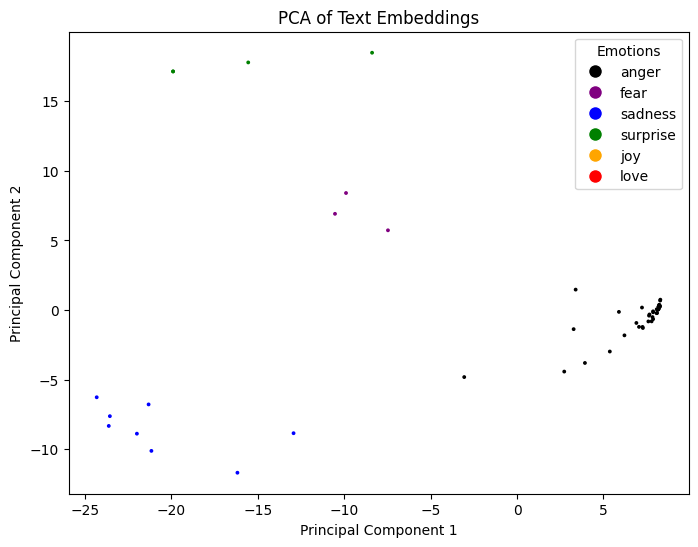

In [45]:
pca_and_plot_2d(embeddings, colors)

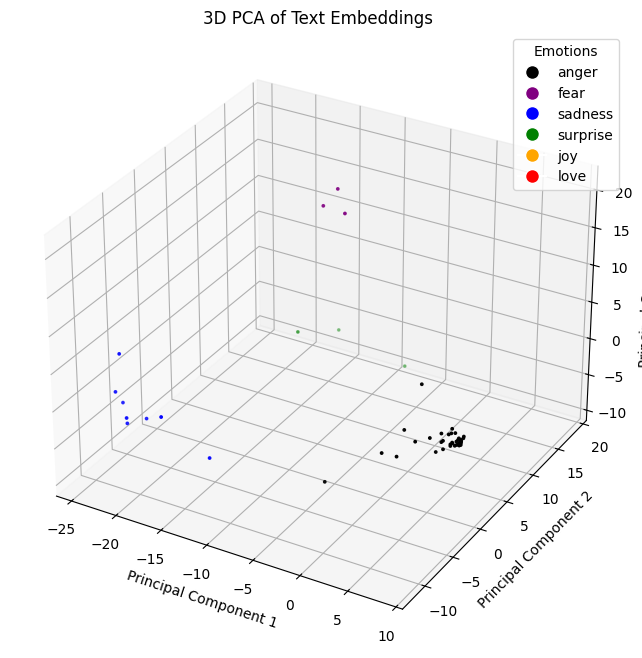

In [46]:
pca_and_plot_3d(embeddings, colors)